In [16]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import glob
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score,
)
from tqdm import tqdm

from data_processing import PointSetDataset
from pointnet_cls import PointNetCls
from pointnet2_cls import get_model

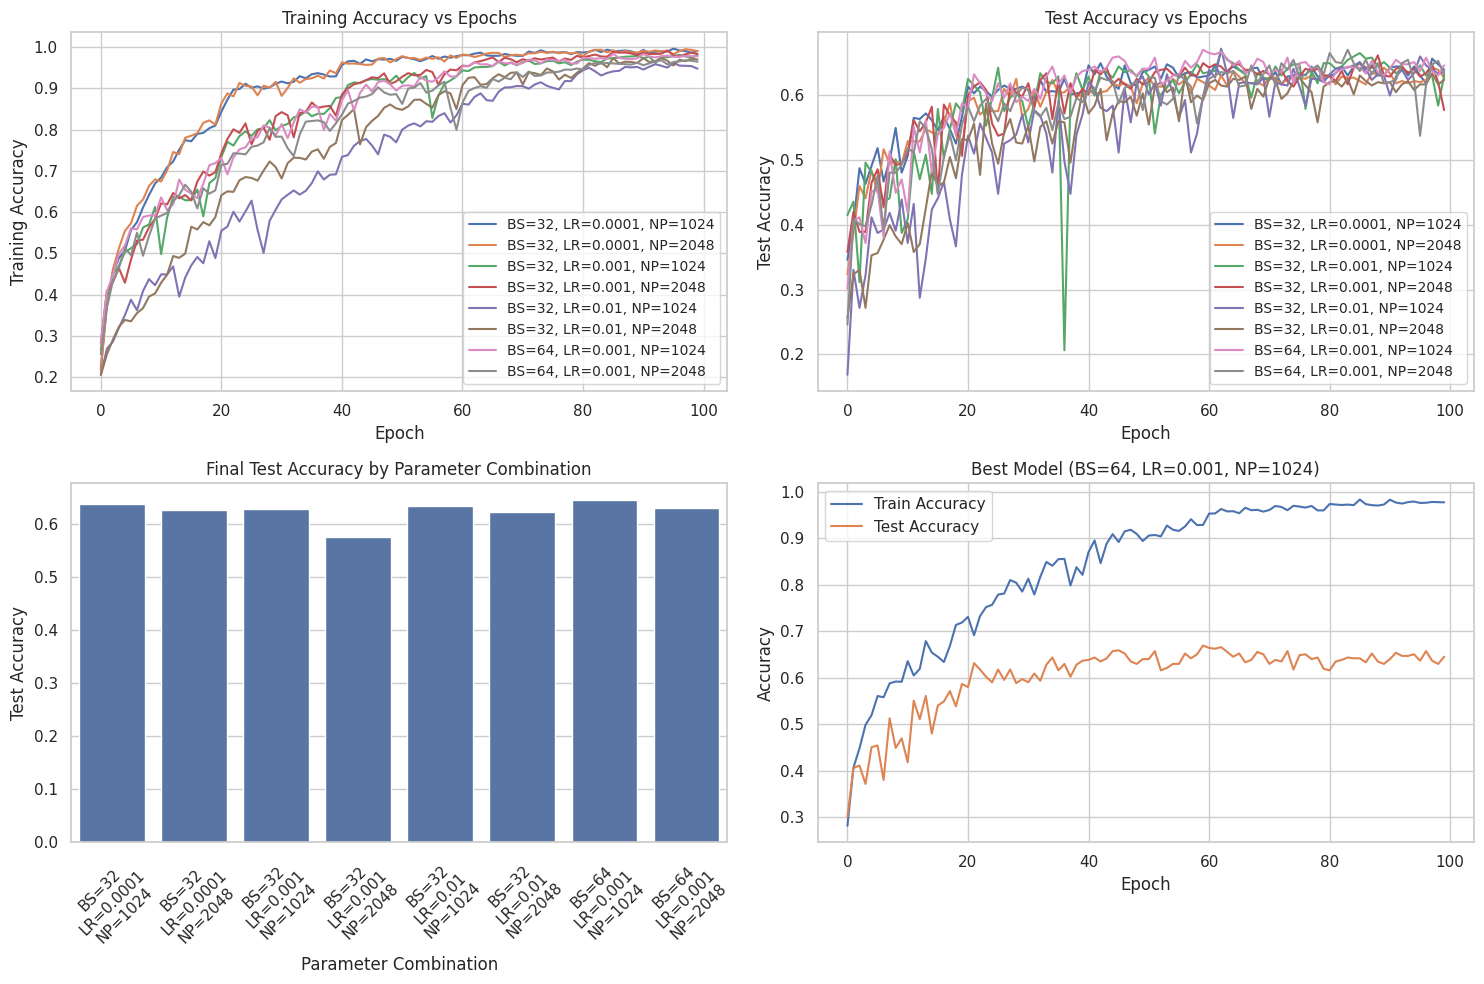

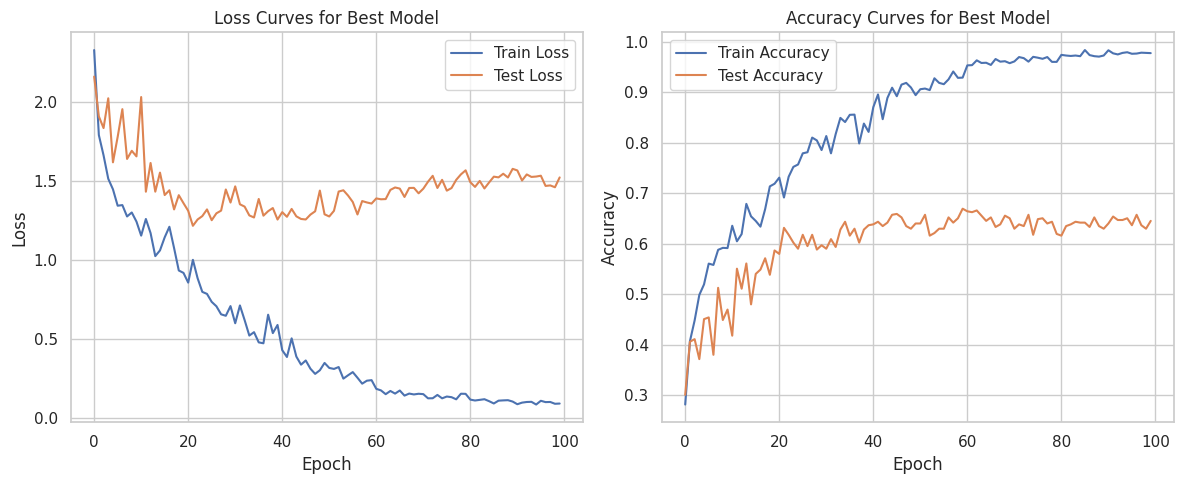


Parametric Study Analysis Summary:

Best model configuration:
  Batch Size: 64
  Learning Rate: 0.001
  Number of Points: 1024
  Test Accuracy: 0.6454

Parameter impact analysis:

  Batch Size effect on test accuracy:
    BS=32: 0.6216
    BS=64: 0.6386

  Learning Rate effect on test accuracy:
    LR=0.0001: 0.6325
    LR=0.001: 0.6209
    LR=0.01: 0.6291

  Number of Points effect on test accuracy:
    NP=1024: 0.6373
    NP=2048: 0.6145


In [8]:
def extract_params(folder_name):
    pattern = r"trained_models_BS_(\d+)_LR_([\d\.]+)_NP_(\d+)"
    match = re.match(pattern, os.path.basename(folder_name))
    if match:
        bs, lr, np_val = match.groups()
        return {
            'batch_size': int(bs),
            'learning_rate': float(lr),
            'num_points': int(np_val)
        }
    return None

def load_training_data(root_dir):
    results = []
    
    # Find all model directories
    model_dirs = glob.glob(os.path.join(root_dir, "trained_models_*"))
    
    for model_dir in model_dirs:
        params = extract_params(model_dir)
        if params is None:
            continue
            
        csv_path = os.path.join(model_dir, "training_report.csv")
        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path)
            df['batch_size'] = params['batch_size']
            df['learning_rate'] = params['learning_rate']
            df['num_points'] = params['num_points']
            results.append(df)
    
    if results:
        return pd.concat(results, ignore_index=True)
    return pd.DataFrame()

def create_plots(data):
    if data.empty:
        print("No data found to plot")
        return
    
    sns.set(style="whitegrid")
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    for params, group in data.groupby(['batch_size', 'learning_rate', 'num_points']):
        bs, lr, np_val = params
        label = f"BS={bs}, LR={lr}, NP={np_val}"
        plt.plot(group['epoch'], group['train_acc'], label=label)
    
    plt.title('Training Accuracy vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Training Accuracy')
    plt.legend(loc='best', fontsize='small')
    
    plt.subplot(2, 2, 2)
    for params, group in data.groupby(['batch_size', 'learning_rate', 'num_points']):
        bs, lr, np_val = params
        label = f"BS={bs}, LR={lr}, NP={np_val}"
        plt.plot(group['epoch'], group['test_acc'], label=label)
    
    plt.title('Test Accuracy vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.legend(loc='best', fontsize='small')
    
    plt.subplot(2, 2, 3)
    
    final_results = data.loc[data.groupby(['batch_size', 'learning_rate', 'num_points'])['epoch'].idxmax()]
    
    final_results['param_combo'] = final_results.apply(
        lambda x: f"BS={int(x['batch_size'])}\nLR={x['learning_rate']}\nNP={int(x['num_points'])}", 
        axis=1
    )
    
    ax = sns.barplot(x='param_combo', y='test_acc', data=final_results)
    plt.title('Final Test Accuracy by Parameter Combination')
    plt.xlabel('Parameter Combination')
    plt.ylabel('Test Accuracy')
    plt.xticks(rotation=45)
    
    # 4. Plot training vs test accuracy for best model
    plt.subplot(2, 2, 4)
    best_model_idx = final_results['test_acc'].idxmax()
    best_params = final_results.loc[best_model_idx, ['batch_size', 'learning_rate', 'num_points']]
    
    best_model_data = data[
        (data['batch_size'] == best_params['batch_size']) & 
        (data['learning_rate'] == best_params['learning_rate']) & 
        (data['num_points'] == best_params['num_points'])
    ]
    
    plt.plot(best_model_data['epoch'], best_model_data['train_acc'], label='Train Accuracy')
    plt.plot(best_model_data['epoch'], best_model_data['test_acc'], label='Test Accuracy')
    plt.title(f'Best Model (BS={int(best_params["batch_size"])}, LR={best_params["learning_rate"]}, NP={int(best_params["num_points"])})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('pointnet_parametric_study_results.png', dpi=300)
    plt.show()
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(best_model_data['epoch'], best_model_data['train_loss'], label='Train Loss')
    plt.plot(best_model_data['epoch'], best_model_data['test_loss'], label='Test Loss')
    plt.title('Loss Curves for Best Model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(best_model_data['epoch'], best_model_data['train_acc'], label='Train Accuracy')
    plt.plot(best_model_data['epoch'], best_model_data['test_acc'], label='Test Accuracy')
    plt.title('Accuracy Curves for Best Model')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('pointnet_learning_curves.png', dpi=300)
    plt.show()

def pointnet_cls_plots():
    root_dir = "pointnet_cls_models"
    
    data = load_training_data(root_dir)

    create_plots(data)
    
    print("\nParametric Study Analysis Summary:")
    
    final_results = data.loc[data.groupby(['batch_size', 'learning_rate', 'num_points'])['epoch'].idxmax()]
    
    best_idx = final_results['test_acc'].idxmax()
    best_model = final_results.loc[best_idx]

    print(f"\nBest model configuration:")
    print(f"  Batch Size: {int(best_model['batch_size'])}")
    print(f"  Learning Rate: {best_model['learning_rate']}")
    print(f"  Number of Points: {int(best_model['num_points'])}")
    print(f"  Test Accuracy: {best_model['test_acc']:.4f}")
    
    print("\nParameter impact analysis:")
    
    if len(final_results['batch_size'].unique()) > 1:
        bs_effect = final_results.groupby('batch_size')['test_acc'].mean()
        print(f"\n  Batch Size effect on test accuracy:")
        for bs, acc in bs_effect.items():
            print(f"    BS={int(bs)}: {acc:.4f}")
    
    if len(final_results['learning_rate'].unique()) > 1:
        lr_effect = final_results.groupby('learning_rate')['test_acc'].mean()
        print(f"\n  Learning Rate effect on test accuracy:")
        for lr, acc in lr_effect.items():
            print(f"    LR={lr}: {acc:.4f}")
    
    if len(final_results['num_points'].unique()) > 1:
        np_effect = final_results.groupby('num_points')['test_acc'].mean()
        print(f"\n  Number of Points effect on test accuracy:")
        for np_val, acc in np_effect.items():
            print(f"    NP={int(np_val)}: {acc:.4f}")

pointnet_cls_plots()

Inference: 100%|██████████| 10/10 [00:00<00:00, 30.62it/s]


Overall Accuracy: 0.5009
              precision    recall  f1-score   support

           0     0.3077    0.2353    0.2667        17
           1     0.4222    0.4750    0.4471        40
           2     0.1892    0.5000    0.2745        28
           3     0.5106    0.3200    0.3934        75
           4     0.7593    0.5256    0.6212        78
           5     0.2581    0.2667    0.2623        30
           6     0.5417    0.6190    0.5778        42
           7     1.0000    0.7381    0.8493        42
           8     0.4268    0.7143    0.5344        49
           9     0.5455    0.4444    0.4898        54
          10     0.5789    0.5000    0.5366        22
          11     0.5789    0.5238    0.5500        21
          12     0.5500    0.4583    0.5000        24
          13     0.7027    0.6190    0.6582        42
          14     0.3529    0.3529    0.3529        17

    accuracy                         0.5009       581
   macro avg     0.5150    0.4862    0.4876       581
w

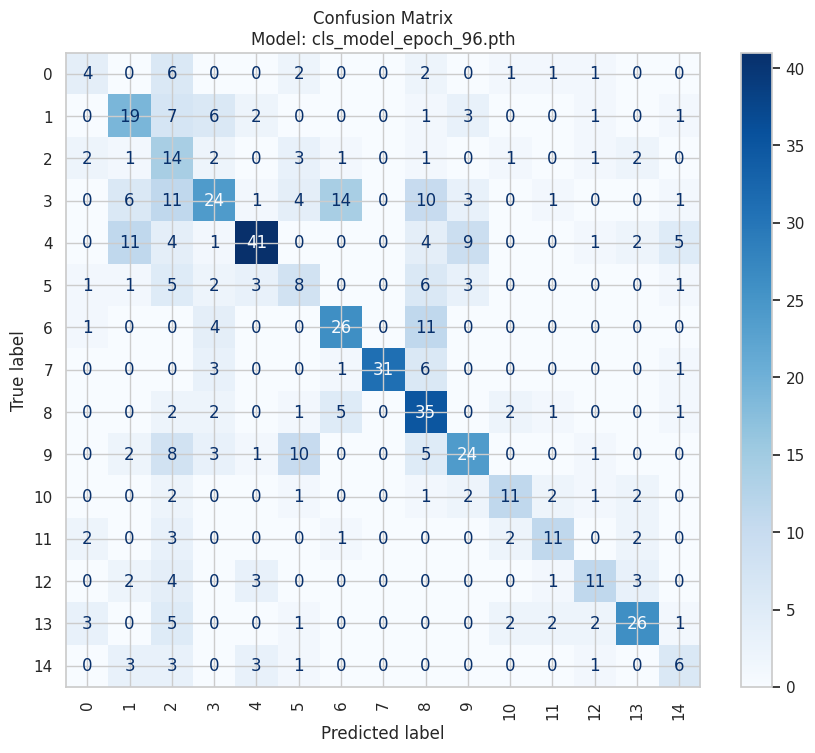

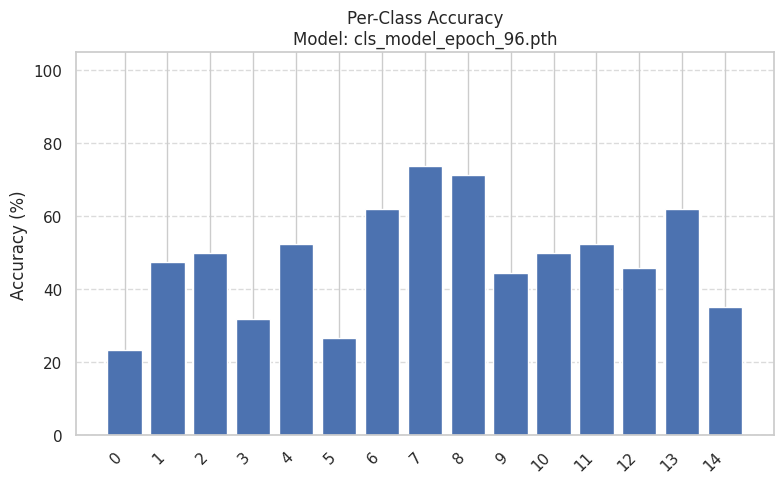

In [12]:
N_POINTS = 1024
BATCH_SIZE = 64
MODEL_PATH = (
    "pointnet_cls_models/trained_models_BS_64_LR_0.001_NP_1024/cls_model_epoch_96.pth"
)
TEST_DATA_PATH = "h5_files/main_split/test_objectdataset.h5"
FEATURE_TRANSFORM = True
OUTPUT_DIR = "pointnet_cls_inference_results"
NUM_WORKERS = 4

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    print(f"Created directory: {OUTPUT_DIR}")

device = torch.device("cuda")


test_dataset = PointSetDataset(TEST_DATA_PATH, npoints=N_POINTS, split="test")
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

num_classes = test_dataset.num_classes
class_names = getattr(test_dataset, "classes", [str(i) for i in range(num_classes)])

classifier = PointNetCls(k=num_classes, feature_transform=FEATURE_TRANSFORM)

classifier.load_state_dict(torch.load(MODEL_PATH, map_location=device))


classifier.to(device)
classifier.eval()

all_preds = []
all_targets = []
with torch.no_grad():
    for data in tqdm(test_loader, desc="Inference"):
        points, target = data
        target = target.long().to(device)

        if points.shape[-1] == 3:
            points = points.transpose(2, 1)
        points = points.float().to(device)

        pred, _, _ = classifier(points)
        pred_choice = pred.data.max(1)[1]

        all_preds.extend(pred_choice.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

accuracy = accuracy_score(all_targets, all_preds)
report = classification_report(
    all_targets, all_preds, target_names=class_names, digits=4, zero_division=0
)
cm = confusion_matrix(all_targets, all_preds)

print(f"Overall Accuracy: {accuracy:.4f}")
print(report)
report_path = os.path.join(OUTPUT_DIR, "classification_report.txt")
with open(report_path, "w") as f:
    f.write(f"Model Path: {MODEL_PATH}\n")
    f.write(f"Test Data Path: {TEST_DATA_PATH}\n")
    f.write(f"Overall Accuracy: {accuracy:.4f}\n\n")
    f.write("Classification Report:\n")
    f.write(report)

fig, ax = plt.subplots(figsize=(max(6, num_classes * 0.6), max(5, num_classes * 0.5)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation="vertical")
plt.title(f"Confusion Matrix\nModel: {os.path.basename(MODEL_PATH)}")
plt.tight_layout()
cm_plot_path = os.path.join(OUTPUT_DIR, "confusion_matrix.png")
plt.plot()
plt.savefig(cm_plot_path)

class_counts = cm.sum(axis=1)
valid_counts = class_counts > 0
per_class_acc = np.zeros_like(class_counts, dtype=float)
per_class_acc[valid_counts] = cm.diagonal()[valid_counts] / class_counts[valid_counts]

fig, ax = plt.subplots(figsize=(max(8, num_classes * 0.4), 5))
ax.bar(class_names, per_class_acc * 100)
ax.set_ylabel("Accuracy (%)")
ax.set_title(f"Per-Class Accuracy\nModel: {os.path.basename(MODEL_PATH)}")
ax.set_ylim(0, 105)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
acc_plot_path = os.path.join(OUTPUT_DIR, "per_class_accuracy.png")
plt.plot()
plt.savefig(acc_plot_path)

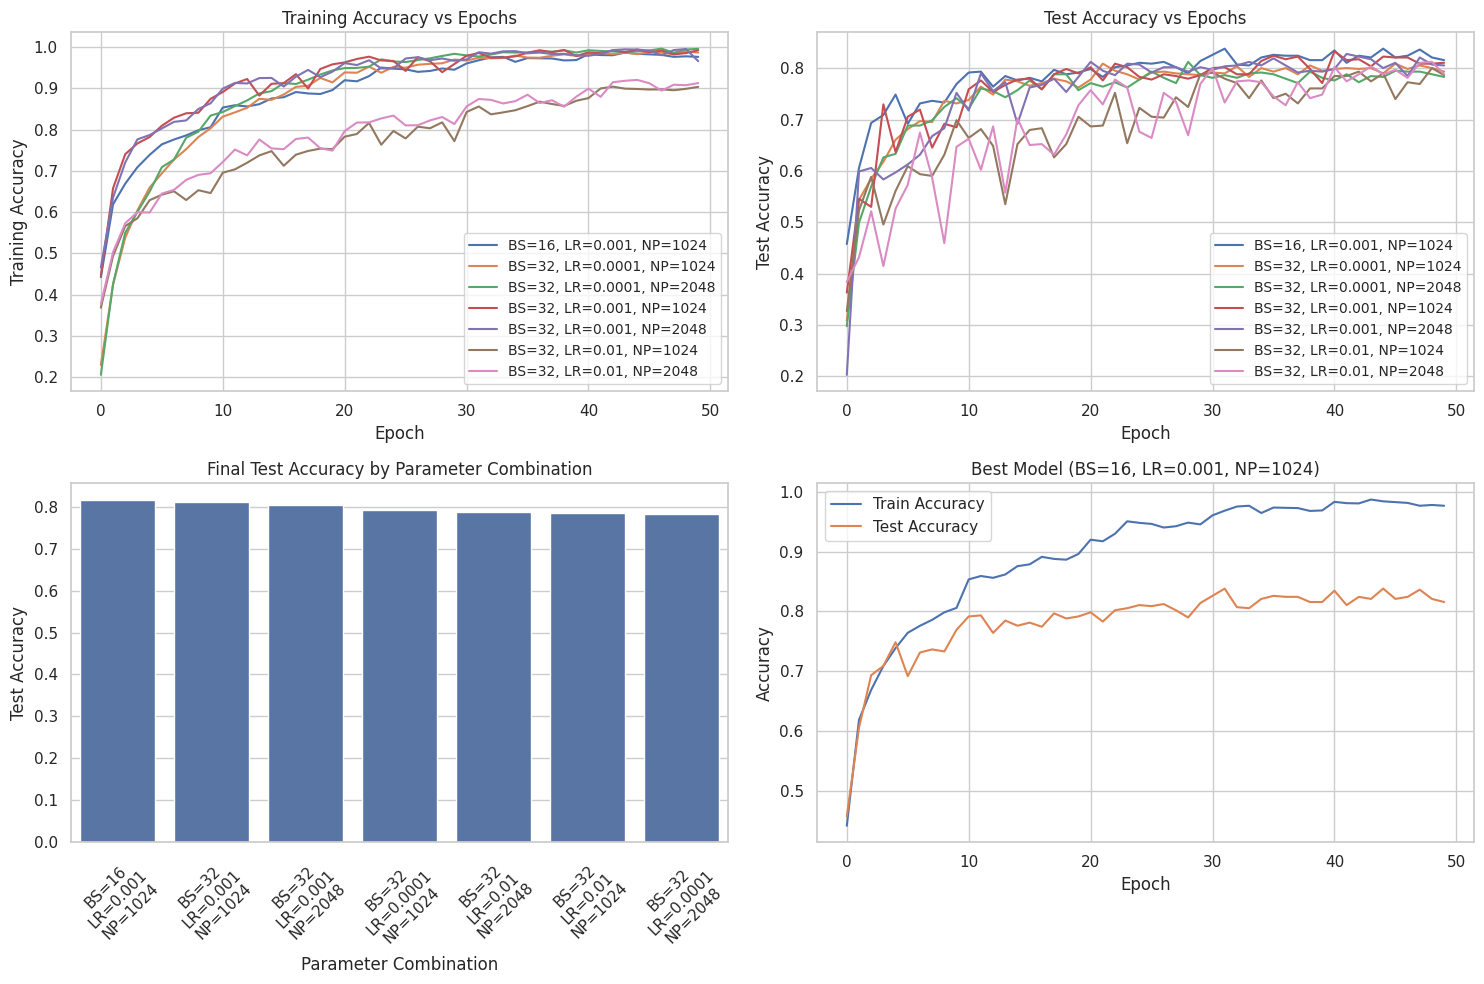

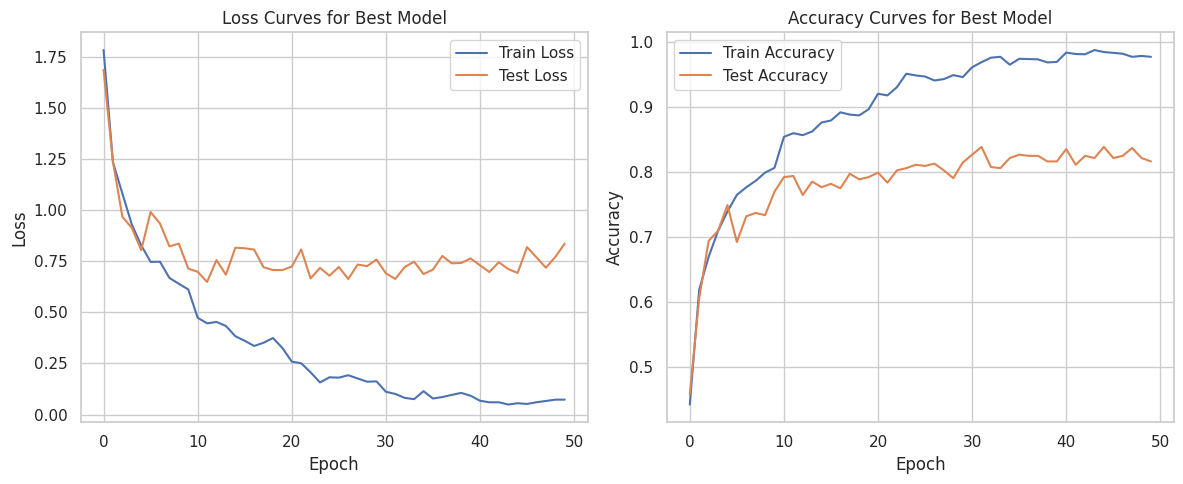


Best model configuration:
  Batch Size: 16
  Learning Rate: 0.001
  Number of Points: 1024
  Test Accuracy: 0.8158

Parameter impact analysis:

  Batch Size effect on test accuracy:
    BS=16: 0.8158
    BS=32: 0.7946

  Learning Rate effect on test accuracy:
    LR=0.0001: 0.7883
    LR=0.001: 0.8107
    LR=0.01: 0.7874

  Number of Points effect on test accuracy:
    NP=1024: 0.8016
    NP=2048: 0.7923


In [ ]:
def extract_params(folder_name):
    pattern = r"trained_models_pn2_BS_(\d+)_LR_([\d\.]+)_NP_(\d+)"
    match = re.match(pattern, os.path.basename(folder_name))
    if match:
        bs, lr, np_val = match.groups()
        return {
            'batch_size': int(bs),
            'learning_rate': float(lr),
            'num_points': int(np_val)
        }
    return None

# Function to load training data from CSV files
def load_training_data(root_dir):
    results = []
    
    # Find all model directories
    model_dirs = glob.glob(os.path.join(root_dir, "trained_models_pn2_*"))
    
    for model_dir in model_dirs:
        params = extract_params(model_dir)
        if params is None:
            continue
            
        csv_path = os.path.join(model_dir, "training_report.csv")
        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path)
            df['batch_size'] = params['batch_size']
            df['learning_rate'] = params['learning_rate']
            df['num_points'] = params['num_points']
            results.append(df)
    
    if results:
        return pd.concat(results, ignore_index=True)
    return pd.DataFrame()

def create_plots(data):
    if data.empty:
        print("No data found to plot")
        return
    
    # Set style
    sns.set(style="whitegrid")
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    for params, group in data.groupby(['batch_size', 'learning_rate', 'num_points']):
        bs, lr, np_val = params
        label = f"BS={bs}, LR={lr}, NP={np_val}"
        plt.plot(group['epoch'], group['train_acc'], label=label)
    
    plt.title('Training Accuracy vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Training Accuracy')
    plt.legend(loc='best', fontsize='small')
    
    # 2. Plot test accuracy over epochs for different models
    plt.subplot(2, 2, 2)
    for params, group in data.groupby(['batch_size', 'learning_rate', 'num_points']):
        bs, lr, np_val = params
        label = f"BS={bs}, LR={lr}, NP={np_val}"
        plt.plot(group['epoch'], group['test_acc'], label=label)
    
    plt.title('Test Accuracy vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.legend(loc='best', fontsize='small')
    
    plt.subplot(2, 2, 3)
    
    final_results = data.loc[data.groupby(['batch_size', 'learning_rate', 'num_points'])['epoch'].idxmax()]
    
    final_results['param_combo'] = final_results.apply(
        lambda x: f"BS={int(x['batch_size'])}\nLR={x['learning_rate']}\nNP={int(x['num_points'])}", 
        axis=1
    )
    
    final_results = final_results.sort_values('test_acc', ascending=False)
    
    ax = sns.barplot(x='param_combo', y='test_acc', data=final_results)
    plt.title('Final Test Accuracy by Parameter Combination')
    plt.xlabel('Parameter Combination')
    plt.ylabel('Test Accuracy')
    plt.xticks(rotation=45)
    
    plt.subplot(2, 2, 4)
    best_model_idx = final_results['test_acc'].idxmax()
    best_params = final_results.loc[best_model_idx, ['batch_size', 'learning_rate', 'num_points']]
    
    best_model_data = data[
        (data['batch_size'] == best_params['batch_size']) & 
        (data['learning_rate'] == best_params['learning_rate']) & 
        (data['num_points'] == best_params['num_points'])
    ]
    
    plt.plot(best_model_data['epoch'], best_model_data['train_acc'], label='Train Accuracy')
    plt.plot(best_model_data['epoch'], best_model_data['test_acc'], label='Test Accuracy')
    plt.title(f'Best Model (BS={int(best_params["batch_size"])}, LR={best_params["learning_rate"]}, NP={int(best_params["num_points"])})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('pointnet2_parametric_study_results.png', dpi=300)
    plt.show()
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(best_model_data['epoch'], best_model_data['train_loss'], label='Train Loss')
    plt.plot(best_model_data['epoch'], best_model_data['test_loss'], label='Test Loss')
    plt.title('Loss Curves for Best Model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(best_model_data['epoch'], best_model_data['train_acc'], label='Train Accuracy')
    plt.plot(best_model_data['epoch'], best_model_data['test_acc'], label='Test Accuracy')
    plt.title('Accuracy Curves for Best Model')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('pointnet2_learning_curves.png', dpi=300)
    plt.show()

def main():
    root_dir = "pointnet2_cls_models"
    
    data = load_training_data(root_dir)
    
    create_plots(data)
    
    final_results = data.loc[data.groupby(['batch_size', 'learning_rate', 'num_points'])['epoch'].idxmax()]
    
    best_idx = final_results['test_acc'].idxmax()
    best_model = final_results.loc[best_idx]
    
    print(f"\nBest model configuration:")
    print(f"  Batch Size: {int(best_model['batch_size'])}")
    print(f"  Learning Rate: {best_model['learning_rate']}")
    print(f"  Number of Points: {int(best_model['num_points'])}")
    print(f"  Test Accuracy: {best_model['test_acc']:.4f}")
    
    print("\nParameter impact analysis:")
    
    if len(final_results['batch_size'].unique()) > 1:
        bs_effect = final_results.groupby('batch_size')['test_acc'].mean()
        print(f"\n  Batch Size effect on test accuracy:")
        for bs, acc in bs_effect.items():
            print(f"    BS={int(bs)}: {acc:.4f}")
    
    if len(final_results['learning_rate'].unique()) > 1:
        lr_effect = final_results.groupby('learning_rate')['test_acc'].mean()
        print(f"\n  Learning Rate effect on test accuracy:")
        for lr, acc in lr_effect.items():
            print(f"    LR={lr}: {acc:.4f}")
    
    if len(final_results['num_points'].unique()) > 1:
        np_effect = final_results.groupby('num_points')['test_acc'].mean()
        print(f"\n  Number of Points effect on test accuracy:")
        for np_val, acc in np_effect.items():
            print(f"    NP={int(np_val)}: {acc:.4f}")

if __name__ == "__main__":
    main()

Inference: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]


Overall Accuracy: 0.6936
              precision    recall  f1-score   support

           0     0.7143    0.5882    0.6452        17
           1     0.8049    0.8250    0.8148        40
           2     0.6154    0.2857    0.3902        28
           3     0.6800    0.6800    0.6800        75
           4     0.9242    0.7821    0.8472        78
           5     0.3846    0.3333    0.3571        30
           6     0.7000    0.8333    0.7609        42
           7     1.0000    0.7857    0.8800        42
           8     0.4112    0.8980    0.5641        49
           9     0.8571    0.5556    0.6742        54
          10     0.8571    0.5455    0.6667        22
          11     0.8571    0.2857    0.4286        21
          12     0.5667    0.7083    0.6296        24
          13     0.7115    0.8810    0.7872        42
          14     0.8889    0.9412    0.9143        17

    accuracy                         0.6936       581
   macro avg     0.7315    0.6619    0.6693       581
w

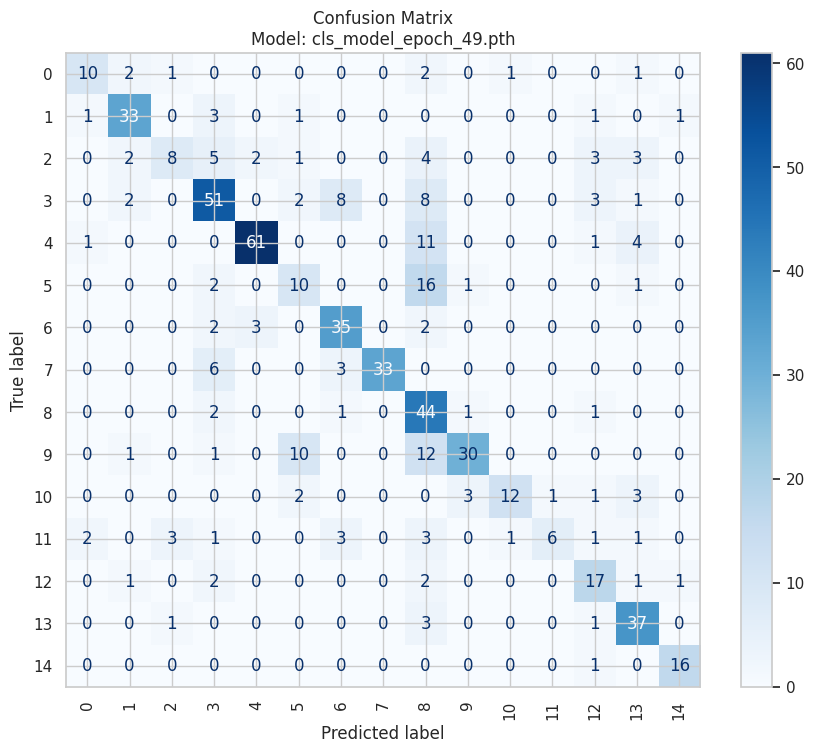

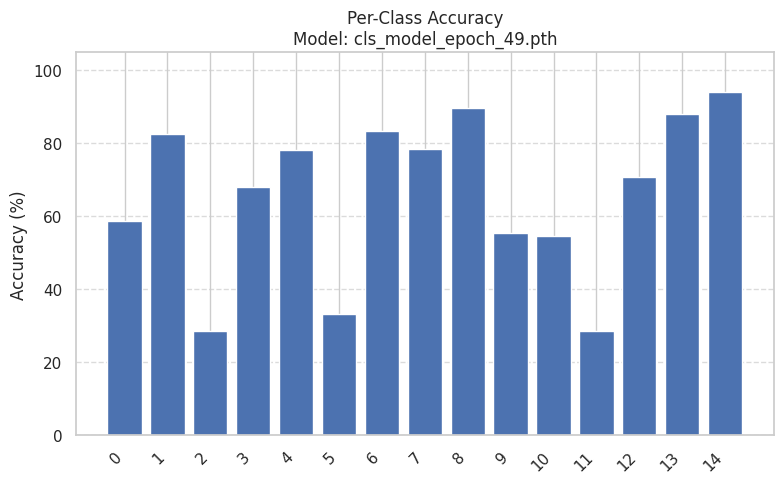

In [19]:
N_POINTS = 1024
BATCH_SIZE = 64
MODEL_PATH = (
    "pointnet2_cls_models/trained_models_pn2_BS_16_LR_0.001_NP_1024/cls_model_epoch_49.pth"
)
TEST_DATA_PATH = "h5_files/main_split/test_objectdataset.h5"
FEATURE_TRANSFORM = True
OUTPUT_DIR = "pointnet_cls_inference_results"
NUM_WORKERS = 4

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    print(f"Created directory: {OUTPUT_DIR}")

device = torch.device("cuda")


test_dataset = PointSetDataset(TEST_DATA_PATH, npoints=N_POINTS, split="test")
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

num_classes = test_dataset.num_classes
class_names = getattr(test_dataset, "classes", [str(i) for i in range(num_classes)])

classifier = get_model(num_class=num_classes, normal_channel=False)

classifier.load_state_dict(torch.load(MODEL_PATH, map_location=device))


classifier.to(device)
classifier.eval()

all_preds = []
all_targets = []
with torch.no_grad():
    for data in tqdm(test_loader, desc="Inference"):
        points, target = data
        target = target.long().to(device)

        if points.shape[-1] == 3:
            points = points.transpose(2, 1)
        points = points.float().to(device)

        pred, _ = classifier(points)
        pred_choice = pred.data.max(1)[1]

        all_preds.extend(pred_choice.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

accuracy = accuracy_score(all_targets, all_preds)
report = classification_report(
    all_targets, all_preds, target_names=class_names, digits=4, zero_division=0
)
cm = confusion_matrix(all_targets, all_preds)

print(f"Overall Accuracy: {accuracy:.4f}")
print(report)
report_path = os.path.join(OUTPUT_DIR, "classification_report.txt")
with open(report_path, "w") as f:
    f.write(f"Model Path: {MODEL_PATH}\n")
    f.write(f"Test Data Path: {TEST_DATA_PATH}\n")
    f.write(f"Overall Accuracy: {accuracy:.4f}\n\n")
    f.write("Classification Report:\n")
    f.write(report)

fig, ax = plt.subplots(figsize=(max(6, num_classes * 0.6), max(5, num_classes * 0.5)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation="vertical")
plt.title(f"Confusion Matrix\nModel: {os.path.basename(MODEL_PATH)}")
plt.tight_layout()
cm_plot_path = os.path.join(OUTPUT_DIR, "confusion_matrix.png")
plt.plot()
plt.savefig(cm_plot_path)

class_counts = cm.sum(axis=1)
valid_counts = class_counts > 0
per_class_acc = np.zeros_like(class_counts, dtype=float)
per_class_acc[valid_counts] = cm.diagonal()[valid_counts] / class_counts[valid_counts]

fig, ax = plt.subplots(figsize=(max(8, num_classes * 0.4), 5))
ax.bar(class_names, per_class_acc * 100)
ax.set_ylabel("Accuracy (%)")
ax.set_title(f"Per-Class Accuracy\nModel: {os.path.basename(MODEL_PATH)}")
ax.set_ylim(0, 105)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
acc_plot_path = os.path.join(OUTPUT_DIR, "per_class_accuracy.png")
plt.plot()
plt.savefig(acc_plot_path)

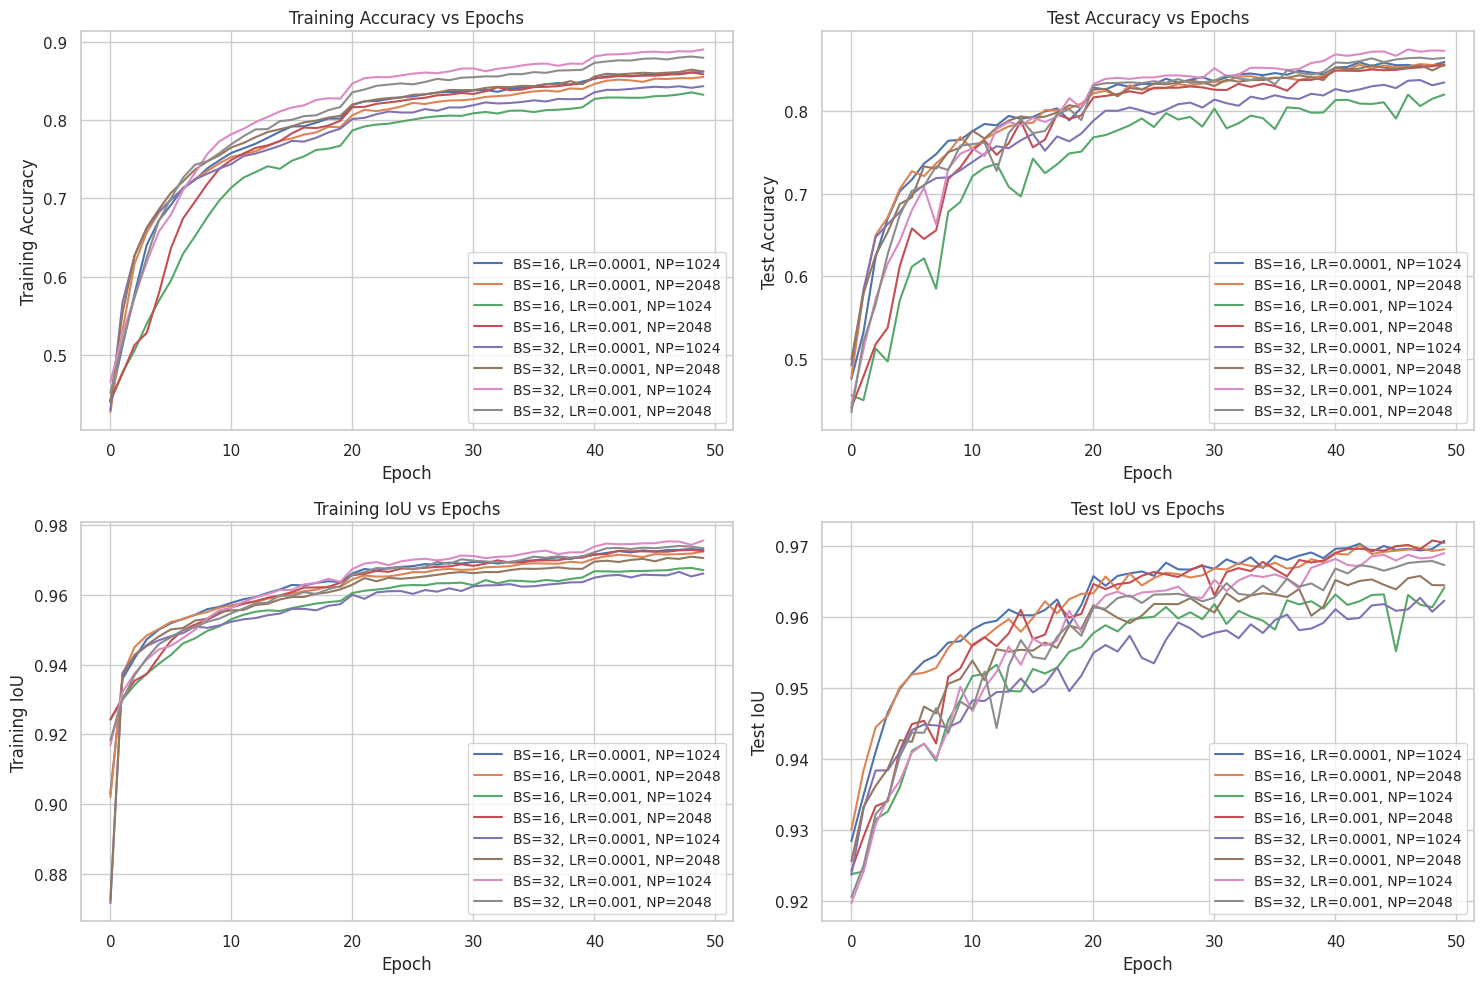

<Figure size 1500x1000 with 0 Axes>

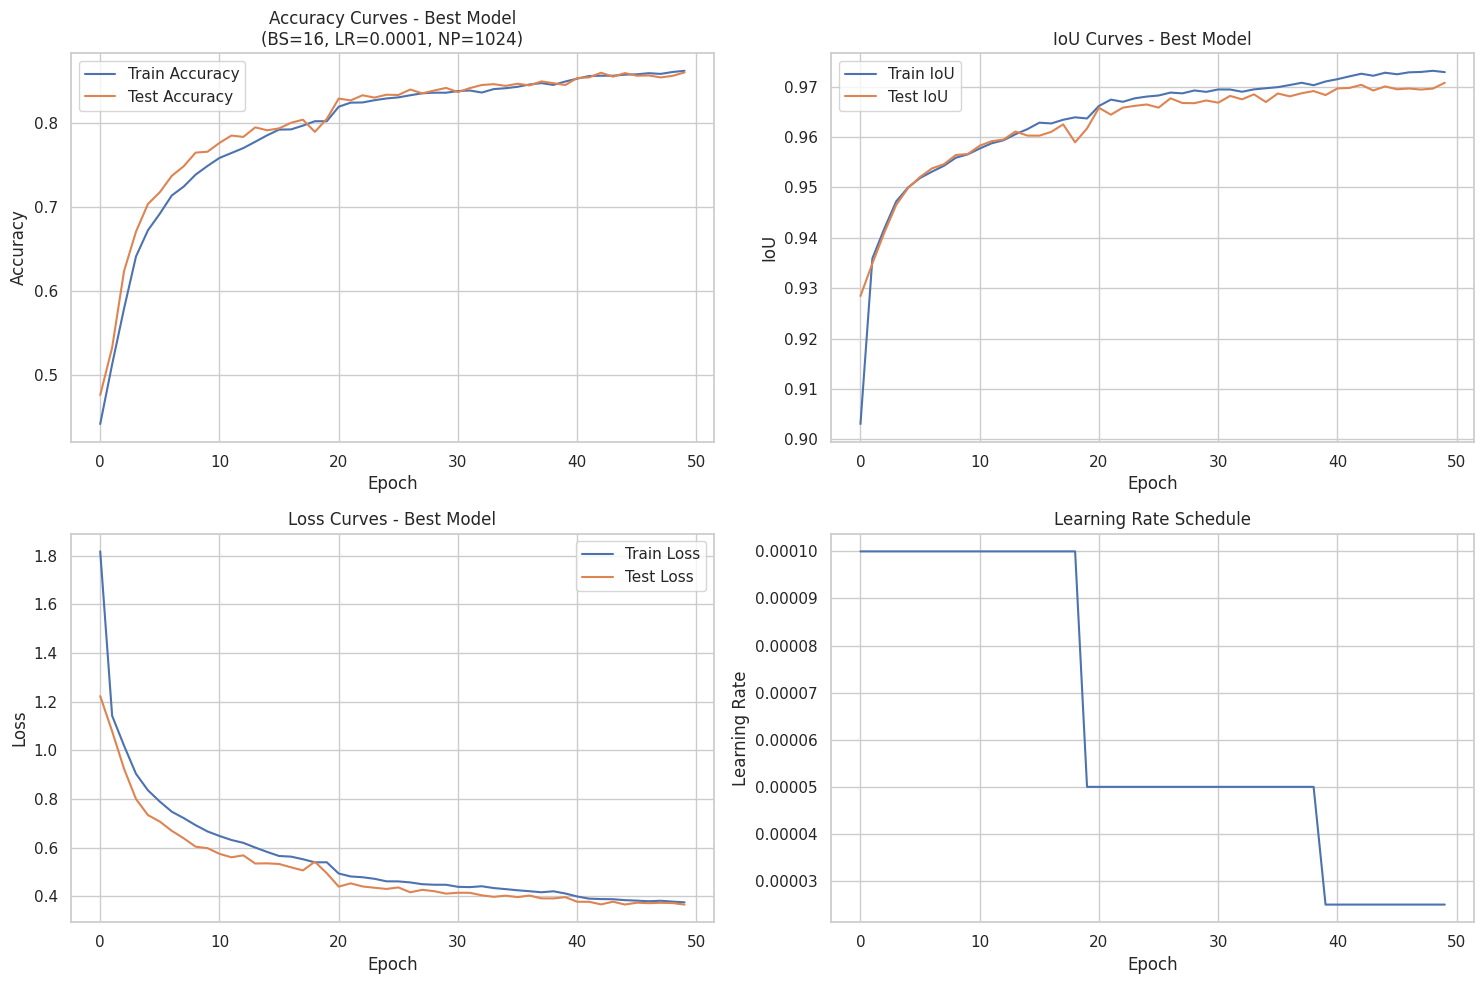


PointNet Segmentation Model Analysis Summary:

Best model configuration (based on Test IoU):
  Batch Size: 16
  Learning Rate: 0.0001
  Number of Points: 1024
  Test IoU: 0.9708
  Test Accuracy: 0.8601

Parameter impact analysis:

  Batch Size effect:
    BS=16: IoU=0.9688, Acc=0.8482
    BS=32: IoU=0.9658, Acc=0.8576

  Learning Rate effect:
    LR=0.0001: IoU=0.9668, Acc=0.8518
    LR=0.001: IoU=0.9678, Acc=0.8541

  Number of Points effect:
    NP=1024: IoU=0.9666, Acc=0.8473
    NP=2048: IoU=0.9680, Acc=0.8585


In [26]:
def extract_params(folder_name):
    pattern = r"trained_models_BS_(\d+)_LR_([\d\.]+)_NP_(\d+)"
    match = re.match(pattern, os.path.basename(folder_name))
    if match:
        bs, lr, np_val = match.groups()
        return {
            'batch_size': int(bs),
            'learning_rate': float(lr),
            'num_points': int(np_val)
        }
    return None

# Function to load training data from CSV files
def load_training_data(root_dir):
    results = []
    
    # Find all model directories
    model_dirs = glob.glob(os.path.join(root_dir, "trained_models_*"))
    
    for model_dir in model_dirs:
        params = extract_params(model_dir)
        if params is None:
            continue
            
        csv_path = os.path.join(model_dir, "training_report.csv")
        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path)
            df['batch_size'] = params['batch_size']
            df['learning_rate'] = params['learning_rate']
            df['num_points'] = params['num_points']
            results.append(df)
    
    if results:
        return pd.concat(results, ignore_index=True)
    return pd.DataFrame()

# Function to create plots for segmentation models
def create_seg_plots(data):
    if data.empty:
        print("No data found to plot")
        return
    
    # Set style
    sns.set(style="whitegrid")
    
    # 1. Plot training and test accuracy plus IoU
    plt.figure(figsize=(15, 10))
    
    # Plot training metrics
    plt.subplot(2, 2, 1)
    for params, group in data.groupby(['batch_size', 'learning_rate', 'num_points']):
        bs, lr, np_val = params
        label = f"BS={bs}, LR={lr}, NP={np_val}"
        plt.plot(group['epoch'], group['train_acc'], label=label)
    
    plt.title('Training Accuracy vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Training Accuracy')
    plt.legend(loc='best', fontsize='small')
    
    # Plot test accuracy
    plt.subplot(2, 2, 2)
    for params, group in data.groupby(['batch_size', 'learning_rate', 'num_points']):
        bs, lr, np_val = params
        label = f"BS={bs}, LR={lr}, NP={np_val}"
        plt.plot(group['epoch'], group['test_acc'], label=label)
    
    plt.title('Test Accuracy vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.legend(loc='best', fontsize='small')
    
    # Plot training IoU
    plt.subplot(2, 2, 3)
    for params, group in data.groupby(['batch_size', 'learning_rate', 'num_points']):
        bs, lr, np_val = params
        label = f"BS={bs}, LR={lr}, NP={np_val}"
        plt.plot(group['epoch'], group['train_iou'], label=label)
    
    plt.title('Training IoU vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Training IoU')
    plt.legend(loc='best', fontsize='small')
    
    # Plot test IoU
    plt.subplot(2, 2, 4)
    for params, group in data.groupby(['batch_size', 'learning_rate', 'num_points']):
        bs, lr, np_val = params
        label = f"BS={bs}, LR={lr}, NP={np_val}"
        plt.plot(group['epoch'], group['test_iou'], label=label)
    
    plt.title('Test IoU vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Test IoU')
    plt.legend(loc='best', fontsize='small')
    
    plt.tight_layout()
    plt.savefig('pointnet_seg_metrics.png', dpi=300)
    plt.show()
    
    # 2. Compare final performance metrics for different parameter combinations
    plt.figure(figsize=(15, 10))
    
    # Get the final epoch for each model
    final_results = data.loc[data.groupby(['batch_size', 'learning_rate', 'num_points'])['epoch'].idxmax()]
    
    # Create parameter combination labels
    final_results['param_combo'] = final_results.apply(
        lambda x: f"BS={int(x['batch_size'])}\nLR={x['learning_rate']}\nNP={int(x['num_points'])}", 
        axis=1
    )
    
    # Sort by test IoU to make the bar chart more readable
    final_results = final_results.sort_values('test_iou', ascending=False)
    
    # 3. Detailed analysis of best model
    best_model_idx = final_results['test_iou'].idxmax()
    best_params = final_results.loc[best_model_idx, ['batch_size', 'learning_rate', 'num_points']]
    
    best_model_data = data[
        (data['batch_size'] == best_params['batch_size']) & 
        (data['learning_rate'] == best_params['learning_rate']) & 
        (data['num_points'] == best_params['num_points'])
    ]
    
    plt.figure(figsize=(15, 10))
    
    # Plot accuracy curves
    plt.subplot(2, 2, 1)
    plt.plot(best_model_data['epoch'], best_model_data['train_acc'], label='Train Accuracy')
    plt.plot(best_model_data['epoch'], best_model_data['test_acc'], label='Test Accuracy')
    plt.title(f'Accuracy Curves - Best Model\n(BS={int(best_params["batch_size"])}, LR={best_params["learning_rate"]}, NP={int(best_params["num_points"])})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot IoU curves
    plt.subplot(2, 2, 2)
    plt.plot(best_model_data['epoch'], best_model_data['train_iou'], label='Train IoU')
    plt.plot(best_model_data['epoch'], best_model_data['test_iou'], label='Test IoU')
    plt.title('IoU Curves - Best Model')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    
    # Plot loss curves
    plt.subplot(2, 2, 3)
    plt.plot(best_model_data['epoch'], best_model_data['train_loss'], label='Train Loss')
    plt.plot(best_model_data['epoch'], best_model_data['test_loss'], label='Test Loss')
    plt.title('Loss Curves - Best Model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot learning rate changes (if available)
    if 'lr' in best_model_data.columns:
        plt.subplot(2, 2, 4)
        plt.plot(best_model_data['epoch'], best_model_data['lr'])
        plt.title('Learning Rate Schedule')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
    
    plt.tight_layout()
    plt.savefig('pointnet_seg_best_model.png', dpi=300)
    plt.show()


# Main function
def main():
    root_dir = "pointnet_seg_models"
    
    # Load the data
    data = load_training_data(root_dir)

    create_seg_plots(data)
    
    # Print analysis summary
    print("\nPointNet Segmentation Model Analysis Summary:")
    
    # Get the final results for each parameter combination
    final_results = data.loc[data.groupby(['batch_size', 'learning_rate', 'num_points'])['epoch'].idxmax()]
    
    # Find best model
    best_idx = final_results['test_iou'].idxmax()
    best_model = final_results.loc[best_idx]
    
    print(f"\nBest model configuration (based on Test IoU):")
    print(f"  Batch Size: {int(best_model['batch_size'])}")
    print(f"  Learning Rate: {best_model['learning_rate']}")
    print(f"  Number of Points: {int(best_model['num_points'])}")
    print(f"  Test IoU: {best_model['test_iou']:.4f}")
    print(f"  Test Accuracy: {best_model['test_acc']:.4f}")
    
    # Analyze impact of different parameters
    print("\nParameter impact analysis:")
    
    # Effect of batch size
    if len(final_results['batch_size'].unique()) > 1:
        bs_effect_iou = final_results.groupby('batch_size')['test_iou'].mean()
        bs_effect_acc = final_results.groupby('batch_size')['test_acc'].mean()
        print(f"\n  Batch Size effect:")
        for bs in bs_effect_iou.index:
            print(f"    BS={int(bs)}: IoU={bs_effect_iou[bs]:.4f}, Acc={bs_effect_acc[bs]:.4f}")
    
    # Effect of learning rate
    if len(final_results['learning_rate'].unique()) > 1:
        lr_effect_iou = final_results.groupby('learning_rate')['test_iou'].mean()
        lr_effect_acc = final_results.groupby('learning_rate')['test_acc'].mean()
        print(f"\n  Learning Rate effect:")
        for lr in lr_effect_iou.index:
            print(f"    LR={lr}: IoU={lr_effect_iou[lr]:.4f}, Acc={lr_effect_acc[lr]:.4f}")
    
    # Effect of number of points
    if len(final_results['num_points'].unique()) > 1:
        np_effect_iou = final_results.groupby('num_points')['test_iou'].mean()
        np_effect_acc = final_results.groupby('num_points')['test_acc'].mean()
        print(f"\n  Number of Points effect:")
        for np_val in np_effect_iou.index:
            print(f"    NP={int(np_val)}: IoU={np_effect_iou[np_val]:.4f}, Acc={np_effect_acc[np_val]:.4f}")
    
if __name__ == "__main__":
    main()

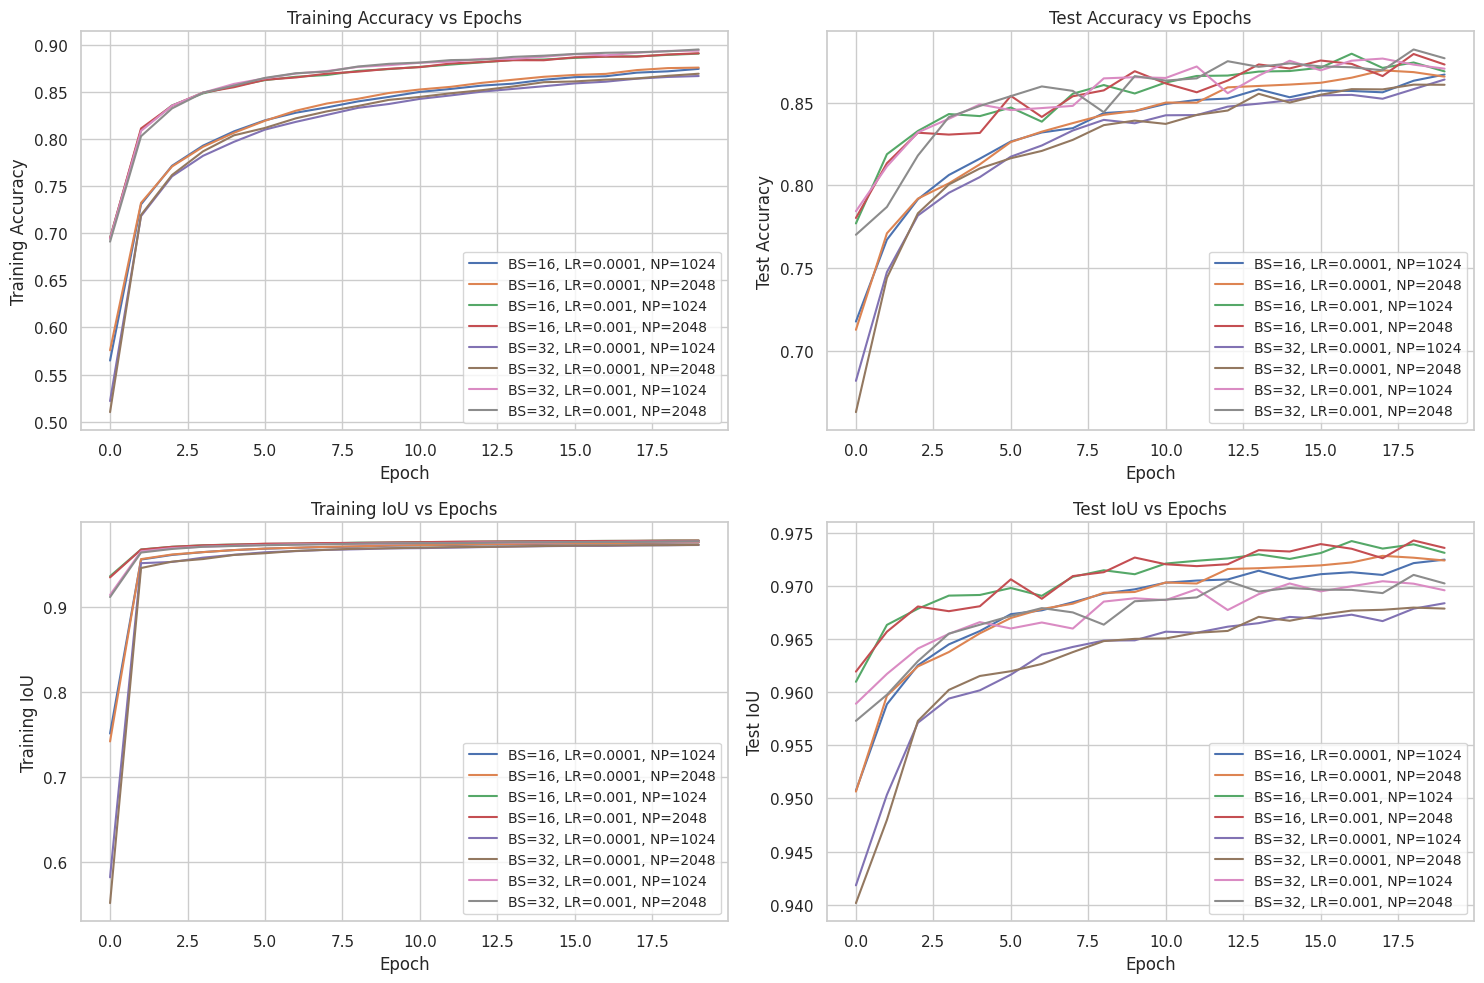

<Figure size 1500x1000 with 0 Axes>

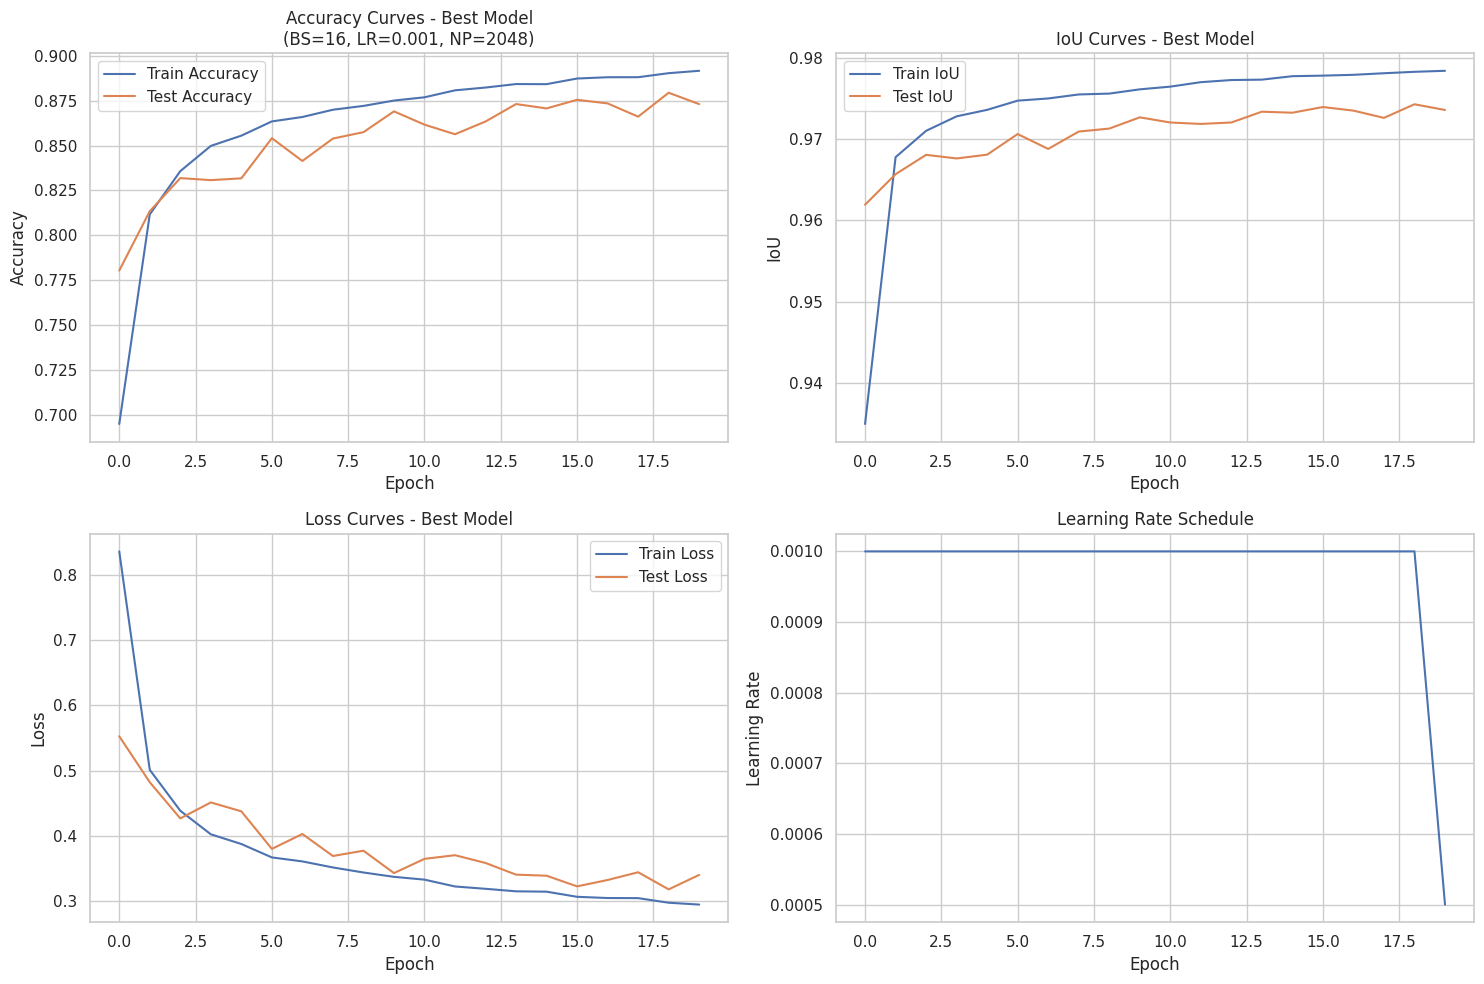


PointNet2 Segmentation Model Analysis Summary:

Best model configuration (based on Test IoU):
  Batch Size: 16
  Learning Rate: 0.001
  Number of Points: 2048
  Test IoU: 0.9736
  Test Accuracy: 0.8730

Parameter impact analysis:

  Batch Size effect:
    BS=16: IoU=0.9729, Acc=0.8687
    BS=32: IoU=0.9690, Acc=0.8680

  Learning Rate effect:
    LR=0.0001: IoU=0.9703, Acc=0.8644
    LR=0.001: IoU=0.9716, Acc=0.8723

  Number of Points effect:
    NP=1024: IoU=0.9709, Acc=0.8676
    NP=2048: IoU=0.9710, Acc=0.8691


In [25]:
def extract_params(folder_name):
    pattern = r"trained_models_pn2_BS_(\d+)_LR_([\d\.]+)_NP_(\d+)"
    match = re.match(pattern, os.path.basename(folder_name))
    if match:
        bs, lr, np_val = match.groups()
        return {
            'batch_size': int(bs),
            'learning_rate': float(lr),
            'num_points': int(np_val)
        }
    return None

# Function to load training data from CSV files
def load_training_data(root_dir):
    results = []
    
    # Find all model directories
    model_dirs = glob.glob(os.path.join(root_dir, "trained_models_*"))
    
    for model_dir in model_dirs:
        params = extract_params(model_dir)
        if params is None:
            continue
            
        csv_path = os.path.join(model_dir, "training_report.csv")
        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path)
            df['batch_size'] = params['batch_size']
            df['learning_rate'] = params['learning_rate']
            df['num_points'] = params['num_points']
            results.append(df)
    
    if results:
        return pd.concat(results, ignore_index=True)
    return pd.DataFrame()

# Function to create plots for segmentation models
def create_seg_plots(data):
    if data.empty:
        print("No data found to plot")
        return
    
    # Set style
    sns.set(style="whitegrid")
    
    # 1. Plot training and test accuracy plus IoU
    plt.figure(figsize=(15, 10))
    
    # Plot training metrics
    plt.subplot(2, 2, 1)
    for params, group in data.groupby(['batch_size', 'learning_rate', 'num_points']):
        bs, lr, np_val = params
        label = f"BS={bs}, LR={lr}, NP={np_val}"
        plt.plot(group['epoch'], group['train_acc'], label=label)
    
    plt.title('Training Accuracy vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Training Accuracy')
    plt.legend(loc='best', fontsize='small')
    
    # Plot test accuracy
    plt.subplot(2, 2, 2)
    for params, group in data.groupby(['batch_size', 'learning_rate', 'num_points']):
        bs, lr, np_val = params
        label = f"BS={bs}, LR={lr}, NP={np_val}"
        plt.plot(group['epoch'], group['test_acc'], label=label)
    
    plt.title('Test Accuracy vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.legend(loc='best', fontsize='small')
    
    # Plot training IoU
    plt.subplot(2, 2, 3)
    for params, group in data.groupby(['batch_size', 'learning_rate', 'num_points']):
        bs, lr, np_val = params
        label = f"BS={bs}, LR={lr}, NP={np_val}"
        plt.plot(group['epoch'], group['train_iou'], label=label)
    
    plt.title('Training IoU vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Training IoU')
    plt.legend(loc='best', fontsize='small')
    
    # Plot test IoU
    plt.subplot(2, 2, 4)
    for params, group in data.groupby(['batch_size', 'learning_rate', 'num_points']):
        bs, lr, np_val = params
        label = f"BS={bs}, LR={lr}, NP={np_val}"
        plt.plot(group['epoch'], group['test_iou'], label=label)
    
    plt.title('Test IoU vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Test IoU')
    plt.legend(loc='best', fontsize='small')
    
    plt.tight_layout()
    plt.savefig('pointnet_seg_metrics.png', dpi=300)
    plt.show()
    
    # 2. Compare final performance metrics for different parameter combinations
    plt.figure(figsize=(15, 10))
    
    # Get the final epoch for each model
    final_results = data.loc[data.groupby(['batch_size', 'learning_rate', 'num_points'])['epoch'].idxmax()]
    
    # Create parameter combination labels
    final_results['param_combo'] = final_results.apply(
        lambda x: f"BS={int(x['batch_size'])}\nLR={x['learning_rate']}\nNP={int(x['num_points'])}", 
        axis=1
    )
    
    # Sort by test IoU to make the bar chart more readable
    final_results = final_results.sort_values('test_iou', ascending=False)
    
    # 3. Detailed analysis of best model
    best_model_idx = final_results['test_iou'].idxmax()
    best_params = final_results.loc[best_model_idx, ['batch_size', 'learning_rate', 'num_points']]
    
    best_model_data = data[
        (data['batch_size'] == best_params['batch_size']) & 
        (data['learning_rate'] == best_params['learning_rate']) & 
        (data['num_points'] == best_params['num_points'])
    ]
    
    plt.figure(figsize=(15, 10))
    
    # Plot accuracy curves
    plt.subplot(2, 2, 1)
    plt.plot(best_model_data['epoch'], best_model_data['train_acc'], label='Train Accuracy')
    plt.plot(best_model_data['epoch'], best_model_data['test_acc'], label='Test Accuracy')
    plt.title(f'Accuracy Curves - Best Model\n(BS={int(best_params["batch_size"])}, LR={best_params["learning_rate"]}, NP={int(best_params["num_points"])})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot IoU curves
    plt.subplot(2, 2, 2)
    plt.plot(best_model_data['epoch'], best_model_data['train_iou'], label='Train IoU')
    plt.plot(best_model_data['epoch'], best_model_data['test_iou'], label='Test IoU')
    plt.title('IoU Curves - Best Model')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    
    # Plot loss curves
    plt.subplot(2, 2, 3)
    plt.plot(best_model_data['epoch'], best_model_data['train_loss'], label='Train Loss')
    plt.plot(best_model_data['epoch'], best_model_data['test_loss'], label='Test Loss')
    plt.title('Loss Curves - Best Model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot learning rate changes (if available)
    if 'lr' in best_model_data.columns:
        plt.subplot(2, 2, 4)
        plt.plot(best_model_data['epoch'], best_model_data['lr'])
        plt.title('Learning Rate Schedule')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
    
    plt.tight_layout()
    plt.savefig('pointnet_seg_best_model.png', dpi=300)
    plt.show()


# Main function
def main():
    root_dir = "pointnet2_seg_models"
    
    # Load the data
    data = load_training_data(root_dir)

    create_seg_plots(data)
    
    # Print analysis summary
    print("\nPointNet2 Segmentation Model Analysis Summary:")
    
    # Get the final results for each parameter combination
    final_results = data.loc[data.groupby(['batch_size', 'learning_rate', 'num_points'])['epoch'].idxmax()]
    
    # Find best model
    best_idx = final_results['test_iou'].idxmax()
    best_model = final_results.loc[best_idx]
    
    print(f"\nBest model configuration (based on Test IoU):")
    print(f"  Batch Size: {int(best_model['batch_size'])}")
    print(f"  Learning Rate: {best_model['learning_rate']}")
    print(f"  Number of Points: {int(best_model['num_points'])}")
    print(f"  Test IoU: {best_model['test_iou']:.4f}")
    print(f"  Test Accuracy: {best_model['test_acc']:.4f}")
    
    # Analyze impact of different parameters
    print("\nParameter impact analysis:")
    
    # Effect of batch size
    if len(final_results['batch_size'].unique()) > 1:
        bs_effect_iou = final_results.groupby('batch_size')['test_iou'].mean()
        bs_effect_acc = final_results.groupby('batch_size')['test_acc'].mean()
        print(f"\n  Batch Size effect:")
        for bs in bs_effect_iou.index:
            print(f"    BS={int(bs)}: IoU={bs_effect_iou[bs]:.4f}, Acc={bs_effect_acc[bs]:.4f}")
    
    # Effect of learning rate
    if len(final_results['learning_rate'].unique()) > 1:
        lr_effect_iou = final_results.groupby('learning_rate')['test_iou'].mean()
        lr_effect_acc = final_results.groupby('learning_rate')['test_acc'].mean()
        print(f"\n  Learning Rate effect:")
        for lr in lr_effect_iou.index:
            print(f"    LR={lr}: IoU={lr_effect_iou[lr]:.4f}, Acc={lr_effect_acc[lr]:.4f}")
    
    # Effect of number of points
    if len(final_results['num_points'].unique()) > 1:
        np_effect_iou = final_results.groupby('num_points')['test_iou'].mean()
        np_effect_acc = final_results.groupby('num_points')['test_acc'].mean()
        print(f"\n  Number of Points effect:")
        for np_val in np_effect_iou.index:
            print(f"    NP={int(np_val)}: IoU={np_effect_iou[np_val]:.4f}, Acc={np_effect_acc[np_val]:.4f}")
    
if __name__ == "__main__":
    main()